In [26]:
from Funcs.Utility import *

# Cross-validation

## Implementation

### CV Pipeline

In [2]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray


@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None


def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    elif alg == 'groupk':
        splitter = GroupKFold(n_splits=n_splits 
)
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None
):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None
):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]

        job = func(
            dir_result=path,
            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state
        )
        jobs.append(job)
    ray.get(jobs)

### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)

## Execution

In [27]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn.permutation_importance import PermutationImportance



RANDOM_STATE = 42

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

# CLS = ['valence', 'arousal', 'stress', 'disturbance']
CLS = ['stress']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_DUMMY),
        oversample=False,
        select=None,
        name='dummy'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

p = os.path.join(PATH_INTERMEDIATE, 'feat',f'stress.pkl')
par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', 'stress')

if os.path.isdir(par_dir):
    # Get a list of all the files in the folder
    files = os.listdir(par_dir)

    # Delete all the files in the folder
    for file in files:
        if file !='.ipynb_checkpoints':
            os.remove(os.path.join(par_dir, file))
os.makedirs(par_dir, exist_ok=True)

#with on_ray(num_cpus=6):
with on_ray():
    for l, s in product(
        CLS, SETTINGS
    ):       
        X, y, groups, t, datetimes = load(p)
        #The following code is for excluding 1st day
        ###########################################
        filtered_df = pd.read_csv(os.path.join(PATH_INTERMEDIATE,'exclude_1st_day.csv'),index_col=0)
        X_filtered = X[X.index.isin(filtered_df.index)]
        y_series = pd.Series(y, index=X.index)
        y_filtered = y_series[y_series.index.isin(filtered_df.index)]
        y_filtered = y_filtered.values
        groups_series = pd.Series(groups, index=X.index)
        groups_filtered = groups_series[groups_series.index.isin(filtered_df.index)]
        groups_filtered = groups_filtered.values
        X,y, groups=X_filtered,y_filtered, groups_filtered
        
        
        ###########################################
        #The following code is for similar-user model
        ###########################################
#         similar_user = pd.read_csv(os.path.join(PATH_INTERMEDIATE,  'similar_user.csv'))
#         cluster_label = similar_user['cluster'].value_counts().index[0] #N number clusters
#         similar_users_in_cluster = similar_user[similar_user['cluster'] == cluster_label]['pcode']

#         # Check if each value in 'groups' is in 'similar_users_in_cluster'
#         mask = np.isin(groups, similar_users_in_cluster)

#         # Filter 'groups' based on the mask
#         filtered_groups = groups[mask]
#         # Filter 'X' and 'y' based on the mask
#         X_filtered = X[mask]
#         y_filtered = y[mask]
#         X,y, groups=X_filtered,y_filtered, filtered_groups
        ###########################################
        
        #Divide the features into different categories
        feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
        feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
        feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
        feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
        feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
        feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
        feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
        feat_ImmediatePast = X.loc[:,[('ImmediatePast' in str(x))  for x in X.keys()]]
        #Divide the time window features into sensor/past stress label
        feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
        feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
        feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
        feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
        feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x)) for x in feat_today.keys()]]  
        feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
        feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
        feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]] 
        #Prepare the final feature set
        feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
        feat_final = pd.concat([feat_current_ESM, feat_today_ESM, feat_today_sensor],axis=1)
        X = feat_final
        
        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split='logo',
            split_params= {'n_splits' : 5},
            random_state=RANDOM_STATE,
            **s
        )

2023-05-28 21:51:39,506	INFO worker.py:1432 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-05-28 21:51:39,523	INFO worker.py:1616 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


(_train pid=45025) [23-05-28 21:51:40] In progress: [dummy#P02] Normalizing numeric features.
(_train pid=45025) [23-05-28 21:51:40] Success: [dummy#P02] Normalizing numeric features (0.14s).
(_train pid=45025) [23-05-28 21:51:40] In progress: [dummy#P02] Training.
(_train pid=1753780, ip=192.168.1.27) [23-05-28 21:51:41] Success: [dummy#P47] Training (0.03s).
(_train pid=1753780, ip=192.168.1.27) [23-05-28 21:51:42] Success: [dummy#P50] Training (0.03s).
(_train pid=1753780, ip=192.168.1.27) [23-05-28 21:51:42] Success: [dummy#P51] Training (0.03s).
(_train pid=1753918, ip=192.168.1.27) [23-05-28 21:51:46] In progress: [dummy#P72] Normalizing numeric features. [repeated 41x across cluster]
(_train pid=1753918, ip=192.168.1.27) [23-05-28 21:51:46] Success: [dummy#P72] Normalizing numeric features (0.08s). [repeated 41x across cluster]
(_train pid=1753918, ip=192.168.1.27) [23-05-28 21:51:46] In progress: [dummy#P72] Training. [repeated 41x across cluster]
(_train pid=1753912, ip=192.16

(_train pid=1753912, ip=192.168.1.27) [23-05-28 21:52:44] Success: [rf_os#P79] Normalizing numeric features (0.11s). [repeated 6x across cluster]
(_train pid=1753912, ip=192.168.1.27) [23-05-28 21:52:44] In progress: [rf_os#P79] 1-th Feature selection. [repeated 6x across cluster]
(_train pid=47016) [23-05-28 21:52:47] Success: [rf_os#P33] Training (8.76s). [repeated 28x across cluster]
(_train pid=1754925, ip=192.168.1.27) [23-05-28 21:52:44] Success: [rf_os#P80] 1-th Feature selection (0.39s). [repeated 4x across cluster]
(_train pid=1754925, ip=192.168.1.27) - # Orig. Feat.: 2791 (# Cat. = 0; # Num. = 2791) [repeated 4x across cluster]
(_train pid=1754925, ip=192.168.1.27) - # Sel. Feat.: 138 (# Cat. = 0; # Num. = 138) [repeated 4x across cluster]
(_train pid=1754925, ip=192.168.1.27) [23-05-28 21:52:44] In progress: [rf_os#P80] Oversampling. [repeated 4x across cluster]
(_train pid=1754925, ip=192.168.1.27) [23-05-28 21:52:44] Success: [rf_os#P80] Oversampling (0.02s). [repeated 2x

# Evaluation

## Implementation

In [28]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:
    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1

    # Ranking Measure
    if is_multiclass:
        for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
            R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                y_true=y_true, y_score=y_prob,
                average=avg, multi_class=mc, labels=classes
            ) if not is_same_y else np.nan
    else:
        R[f'roauc'] = roc_auc_score(
            y_true=y_true, y_score=y_prob[:, 1], average=None
        ) if not is_same_y else np.nan
        for i, c in enumerate(classes):
            R[f'prauc_{c}'] = average_precision_score(
                y_true=y_true, y_score=y_prob[:, i], pos_label=c, average=None
            ) 
            R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)

    # Probability Measure
    R['log_loss'] = log_loss(y_true=y_true, y_pred=y_prob, labels=classes, normalize=True)

    if not is_multiclass:
        R[f'brier_loss'] = brier_score_loss(
            y_true=y_true, y_prob=y_prob[:, 1], pos_label=classes[1]
        )

    return R

## Execution

In [29]:
import os
import pandas as pd


RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

#for l in ['valence', 'arousal', 'disturbance', 'stress']:
for l in [ 'stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        if f == '.ipynb_checkpoints':
            continue
        model, pid = f[:f.index('.pkl')].split('#')
        res = load(os.path.join(dir_l, f))
        X, y = res.X_test, res.y_test
        y_pred = res.estimator.predict(X)
        y_prob = res.estimator.predict_proba(X)
        ev_test = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_prob=y_prob,
            classes=[0, 1]
        )

        X, y = res.X_train, res.y_train
        y_pred = res.estimator.predict(X)
        y_prob = res.estimator.predict_proba(X)
        ev_train = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_prob=y_prob,
            classes=[0, 1]
        )

        RESULTS_EVAL.append({
            'label': l,
            'alg': model,
            'split': pid,
            'n_feature': len(X.columns),
            **{
                f'test_{k}': v for k, v in ev_test.items()
            },
            **{
                f'train_{k}': v for k, v in ev_train.items()
            }
        })
    
RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL.head()

/home/iclab1209/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_32375/30616146.py:42: RuntimeWarning: invalid value encountered in divide
  R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
/home/iclab1209/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/tmp/ipykernel_32375/30616146.py:42: RuntimeWarning: invalid value encountered in divide
  R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
/home/iclab1209/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/iclab1209/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn

,label,alg,split,n_feature,test_inst,test_inst_0,test_inst_1,test_class_ratio,test_true_0_pred_0,test_true_0_pred_1,...,train_pre_1,train_rec_1,train_f1_1,train_roauc,train_prauc_0,train_prauc_ref_0,train_prauc_1,train_prauc_ref_1,train_log_loss,train_brier_loss
0,stress,rf_ns,P42,124,57,19,38,0.500000,9,10,...,0.954710,0.945291,0.949977,0.992216,0.992154,0.490402,0.992640,0.509598,0.173607,0.043792
1,stress,rf_os,P49,135,70,48,22,2.181818,42,6,...,0.951456,0.953139,0.952297,0.993132,0.993332,0.500000,0.993232,0.500000,0.169846,0.042335
2,stress,xgb_ns,P55,131,49,27,22,1.227273,23,4,...,0.937557,0.902741,0.919820,0.977657,0.975909,0.484973,0.979965,0.515027,0.219437,0.061594
3,stress,xgb_os,P52,131,36,24,12,2.000000,22,2,...,0.942910,0.897458,0.919623,0.977256,0.977019,0.500000,0.978365,0.500000,0.230496,0.063416
4,stress,xgb_os,P69,134,64,27,37,0.729730,27,0,...,0.927456,0.905018,0.916100,0.976368,0.975964,0.500000,0.978053,0.500000,0.227396,0.063764


In [30]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
    ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL.head()

,label,alg,metric,n,cardinality,value_count,sum,mean,SD,med,range,conf.,nan_count
0,stress,dummy,split,47,47.0,"P77:1, P13:1, P60:1, P80:1, P61:1, P23:1, P55:...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stress,dummy,n_feature,47,NaN,NaN,131177.0,2791.000000,0.000000,2791.0,"(2791, 2791)","(nan, nan)",0.0
2,stress,dummy,test_inst,47,NaN,NaN,2245.0,47.765957,11.591250,46.0,"(30, 70)","(44.36263895311653, 51.1692759405005)",0.0
3,stress,dummy,test_inst_0,47,NaN,NaN,1092.0,23.234043,12.724869,21.0,"(0, 48)","(19.497881019487878, 26.9702040868951)",0.0
4,stress,dummy,test_inst_1,47,NaN,NaN,1153.0,24.531915,13.051488,21.0,"(4, 66)","(20.699854334552278, 28.363975452681764)",0.0


In [31]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature', 'train_class_ratio', 'train_inst_0', 'train_inst_1', 'test_inst_0', 'test_inst_1', 'test_bac', 'test_f1_0' ,'test_f1_1', 'test_f1_macro', 'train_f1_0' ,'train_f1_1', 'train_f1_macro',]
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep='')
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)
SUB_SUMMARY_EVAL

mean_sd                                               \
metric               n_feature       test_bac      test_f1_0      test_f1_1   
label  alg                                                                    
stress dummy      2791.0 (0.0)  0.511 (0.073)  0.001 (0.008)  0.627 (0.218)   
       rf_ns   136.213 (4.452)  0.729 (0.108)  0.702 (0.239)  0.739 (0.163)   
       rf_os   136.213 (4.452)  0.725 (0.106)   0.71 (0.224)  0.727 (0.171)   
       xgb_ns  136.213 (4.452)   0.757 (0.09)  0.732 (0.215)   0.76 (0.145)   
       xgb_os  136.213 (4.452)  0.752 (0.091)   0.73 (0.216)  0.749 (0.149)   

                                                                \
metric         test_f1_macro      test_inst_0      test_inst_1   
label  alg                                                       
stress dummy   0.325 (0.145)  23.234 (12.725)  24.532 (13.051)   
       rf_ns   0.721 (0.108)  23.234 (12.725)  24.532 (13.051)   
       rf_os   0.719 (0.109)  23.234 (12.725)  24.532 (13.051)   
       xgb_ns  0.746 (0.101)  23.234 (12.725)  24.532 (13.051)   
       xgb_os  0.739 (0.101)  23.234 (12.725)  24.532 (13.051)   

                                                                              \
metric        train_class_ratio     train_f1_0     train_f1_1 train_f1_macro   
label  alg                                                                     
stress dummy       0.947 (0.02)  0.014 (0.097)  0.664 (0.099)  0.339 (0.002)   
       rf_ns       0.947 (0.02)  0.949 (0.001)  0.951 (0.001)   0.95 (0.001)   
       rf_os          1.0 (0.0)  0.952 (0.001)  0.951 (0.001)  0.951 (0.001)   
       xgb_ns      0.947 (0.02)  0.919 (0.006)  0.922 (0.006)   0.92 (0.006)   
       xgb_os         1.0 (0.0)  0.923 (0.006)  0.921 (0.006)  0.922 (0.006)   

                                                     
metric              train_inst_0       train_inst_1  
label  alg                                           
stress dummy   1068.766 (12.725)  1128.468 (13.051)  
       rf_ns   1068.766 (12.725)  1128.468 (13.051)  
       rf_os    1128.532 (12.85)   1128.532 (12.85)  
       xgb_ns  1068.766 (12.725)  1128.468 (13.051)  
       xgb_os   1128.532 (12.85)   1128.532 (12.85)

# Feature Importances

## Implementation

In [287]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [288]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

# for l in ['valence', 'arousal', 'disturbance', 'stress']:
for l in ['stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        if f!='.ipynb_checkpoints':
            res = load(os.path.join(dir_l, f))

            f_norm = f[:f.index('.pkl')]
            alg = f_norm[:f.rindex('#')]

            feat_imp = feature_importance(res.estimator)
            if not feat_imp:
                continue

            names, importance = feat_imp
            new_names = []
            for n in names:
                for c in res.categories:
                    n = n.replace(f'{c}_', f'{c}=')
                new_names.append(n)

            d = pd.DataFrame(
                importance.reshape(1, -1),
                columns=new_names
            )
            IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)

### Plot

In [278]:
%load_ext rpy2.ipython

In [280]:
%%R

library(tidyverse)
library(ggforce)
library(ggpubr)
library(showtext)
library(rmcorr)
library(patchwork)

font_add_google(
    name='Source Serif Pro',
    family='ssp',
    db_cache=FALSE
)

showtext_auto()

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='ssp',
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.background=element_blank(),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm'),
        plot.subtitle=element_text(colour='grey20', size=10, hjust=.5),
    )


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Loading required package: sysfonts

R[write to console]: Loading required package: showtextdb



/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "feature". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'numpy.str_'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


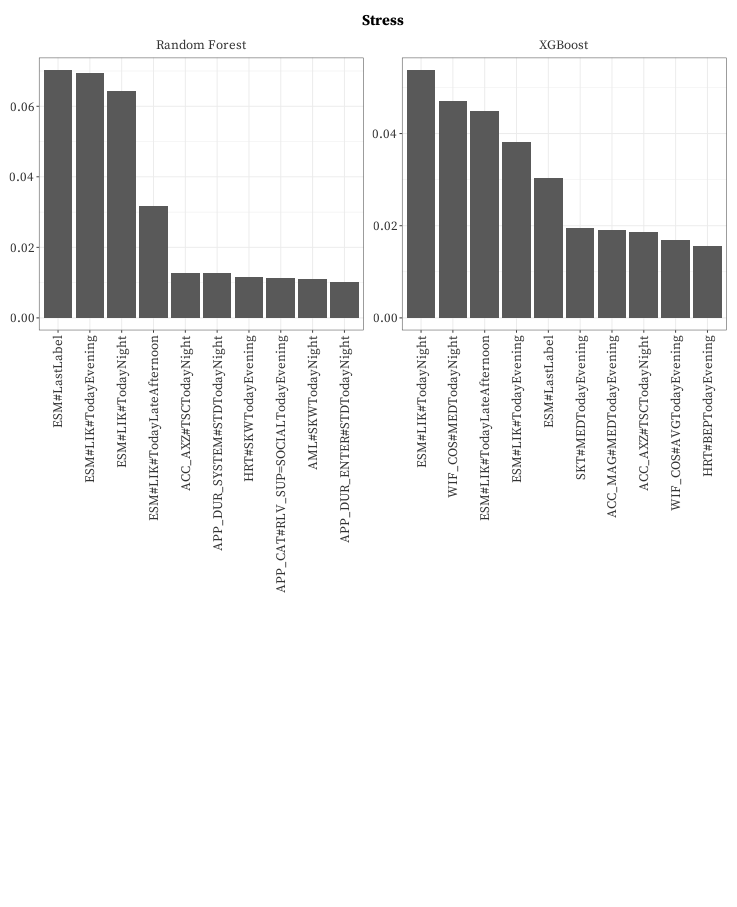

In [289]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 32 -u cm

plots <- list()

#for (l in c('valence', 'arousal', 'stress', 'disturbance')) {
for (l in c( 'stress')) {
    data <- IMPORTANCE_SUMMARY %>% filter(
        (label == l)
    )

    p_label <- ggplot() + geom_text(
        aes(x=.5, y=.5),
        label=str_to_title(l), 
        family='ssp', 
        fontface='bold',
        size=4
    ) + theme_void()

    p_rf <- ggplot(
        data %>% filter(alg == 'rf_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='Random Forest'
    )
    
    p_xgb <- ggplot(
        data %>% filter(alg == 'xgb_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='XGBoost'
    )
    
    plots[[paste(l, 'label', sep='_')]] <- p_label
    plots[[paste(l, 'rf', sep='_')]] <- p_rf
    plots[[paste(l, 'xgb', sep='_')]] <- p_xgb
}

#p <- plots$arousal_label + plots$valence_label
#p <- p / (plots$arousal_rf | plots$arousal_xgb | plots$valence_rf | plots$valence_xgb)
#p <- p / (plots$stress_label + plots$disturbance_label)
#p <- p / (plots$stress_rf | plots$stress_xgb | plots$disturbance_rf | plots$disturbance_xgb)
p <- plots$stress_label 
p <- p / (plots$stress_rf | plots$stress_xgb)

p <- p + plot_layout(
    heights=c(1.1, 10, 1.1, 10)
)

ggsave(paste('./fig/imp.pdf'), plot=p, width=26, height=32, unit='cm', device=cairo_pdf)
print(p)
